In [4]:
# --- 1. Setup and Imports ---
import os
import zipfile
import requests
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import librosa
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, roc_auc_score

# Verify GPU is working and set the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [5]:
# --- 2. Download Data (Once) and Prepare File Lists ---
DATASET_URL = "https://zenodo.org/record/3384388/files/6_dB_fan.zip?download=1"
DATA_DIR = "data"
ZIP_PATH = os.path.join(DATA_DIR, "6_dB_fan.zip")
EXTRACTED_FAN_DIR = os.path.join(DATA_DIR, "fan") 

os.makedirs(DATA_DIR, exist_ok=True)
if not os.path.exists(EXTRACTED_FAN_DIR):
    if not os.path.exists(ZIP_PATH):
        print("Downloading 6dB fan dataset... This is a one-time download.")
        with requests.get(DATASET_URL, stream=True) as r:
            r.raise_for_status()
            with open(ZIP_PATH, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192): f.write(chunk)
    print("Extracting files...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
else:
    print("Dataset already downloaded and extracted.")

# Use the 'id_06' fan model, which had the best results in the paper
FAN_MODEL_ID = "id_06"
NORMAL_DIR = os.path.join(EXTRACTED_FAN_DIR, FAN_MODEL_ID, "normal") 
ABNORMAL_DIR = os.path.join(EXTRACTED_FAN_DIR, FAN_MODEL_ID, "abnormal")

normal_files = [os.path.join(NORMAL_DIR, f) for f in os.listdir(NORMAL_DIR) if f.endswith('.wav')]
abnormal_files = [os.path.join(ABNORMAL_DIR, f) for f in os.listdir(ABNORMAL_DIR) if f.endswith('.wav')]

# Split data according to the paper's method
num_abnormal = len(abnormal_files)
shuffled_normal_files = np.random.permutation(normal_files)
test_normal_files = shuffled_normal_files[:num_abnormal]
train_files = shuffled_normal_files[num_abnormal:]
print(f"\nUsing data from 'data/fan/{FAN_MODEL_ID}': {len(train_files)} train, {len(test_normal_files)} normal test, {len(abnormal_files)} abnormal test files.")

Dataset already downloaded and extracted.

Using data from 'data/fan/id_06': 654 train, 361 normal test, 361 abnormal test files.


In [6]:
# --- 3. Create the 2D Spectrogram Dataset and DataLoaders ---
class SpectrogramDataset(Dataset):
    def __init__(self, file_list, is_normal=True):
        self.file_list = file_list
        self.label = 1 if is_normal else 0 # 1 for Normal, 0 for Abnormal

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        y, sr = librosa.load(file_path, sr=16000)
        
        # Create a log-Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=512, n_mels=64)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # Normalize the spectrogram (instance normalization)
        log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()

        # Ensure all spectrograms have the same width
        target_width = 313 
        if log_mel_spectrogram.shape[1] < target_width:
            pad_width = target_width - log_mel_spectrogram.shape[1]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:, :target_width]

        # Add a channel dimension for the CNN and return with label
        return torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0), self.label

# Create PyTorch datasets
train_dataset = SpectrogramDataset(train_files, is_normal=True)
test_normal_dataset = SpectrogramDataset(test_normal_files, is_normal=True)
test_abnormal_dataset = SpectrogramDataset(abnormal_files, is_normal=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(torch.utils.data.ConcatDataset([test_normal_dataset, test_abnormal_dataset]), batch_size=32, shuffle=False)

print("\nDataLoaders created successfully.")
print(f"Shape of one data sample: {next(iter(train_loader))[0].shape}")


DataLoaders created successfully.
Shape of one data sample: torch.Size([512, 1, 64, 313])


In [9]:
train_dataset[0]

(tensor([[[ 1.0440,  0.5006,  0.6325,  ...,  1.0528,  0.6806,  1.3473],
          [ 0.9254,  1.2475,  1.0901,  ...,  1.0600,  1.0453,  1.2103],
          [ 0.9717,  1.5624,  1.2781,  ...,  0.5240,  0.8638,  1.3323],
          ...,
          [-2.0648, -1.7057, -1.6364,  ..., -1.5938, -1.7233, -1.4290],
          [-1.7958, -1.8281, -1.5040,  ..., -1.6390, -1.6531, -1.6272],
          [-2.0230, -1.9826, -1.7170,  ..., -1.8465, -1.6918, -1.6663]]]),
 1)

In [20]:
train_dataset[0][0].shape

torch.Size([1, 64, 313])

In [22]:
# --- 4: The Convolutional Autoencoder (CAE) Model ---
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder: Reduces the image dimensions
        self.encoder = nn.Sequential(
    nn.Conv2d(1, 16, 3, 2, 1),   # -> [N, 16, 32, 157]
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, 2, 1),  # -> [N, 32, 16, 79]
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 2, 1),  # -> [N, 64, 8, 40]
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, 2, 1), # -> [N, 128, 4, 20]
    nn.ReLU()
)
        self.decoder = nn.Sequential(
    nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1, 3, 2, 1, 1)
)

        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, optimizer, and loss function
model = ConvAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Convolutional Autoencoder model created successfully.")
print(model)

Convolutional Autoencoder model created successfully.
ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


In [24]:
# --- 5: Training the CAE Model ---
num_epochs = 50

print("\n--- Starting CAE Training ---")
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    
    for inputs, _ in loop:
        inputs = inputs.to(DEVICE)
        
        # Forward pass
        outputs = model(inputs)
        
        # CRITICAL: Crop the output to match the input's exact size before calculating loss
        target_size = inputs.size()[2:] # Get [height, width] of the input
        outputs = outputs[:, :, :target_size[0], :target_size[1]]
        
        # Calculate loss
        loss = criterion(outputs, inputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

print("\nTraining finished.")
torch.save(model.state_dict(), 'cae_autoencoder.pth')
print("Model saved to 'cae_autoencoder.pth'")


--- Starting CAE Training ---


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/50, Average Loss: 0.995922


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/50, Average Loss: 0.469136


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/50, Average Loss: 0.190532


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/50, Average Loss: 0.104795


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/50, Average Loss: 0.078545


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/50, Average Loss: 0.066517


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/50, Average Loss: 0.061598


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/50, Average Loss: 0.057261


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/50, Average Loss: 0.054048


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/50, Average Loss: 0.051115

Training finished.
Model saved to 'cae_autoencoder.pth'



Determining anomaly threshold...


C:\Users\wasae\AppData\Local\Temp\ipykernel_18992\628892367.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cae_autoencoder.pth'))


Calculating normal errors:   0%|          | 0/361 [00:00<?, ?it/s]

Anomaly threshold determined: 0.096447

Evaluating model on the full test set...


Evaluating test set:   0%|          | 0/23 [00:00<?, ?it/s]


--- FINAL CLASSIFICATION REPORT (CAE Model) ---
              precision    recall  f1-score   support

    Abnormal       0.97      0.72      0.82       361
      Normal       0.78      0.98      0.87       361

    accuracy                           0.85       722
   macro avg       0.87      0.85      0.85       722
weighted avg       0.87      0.85      0.85       722


--- VISUALIZATION ---


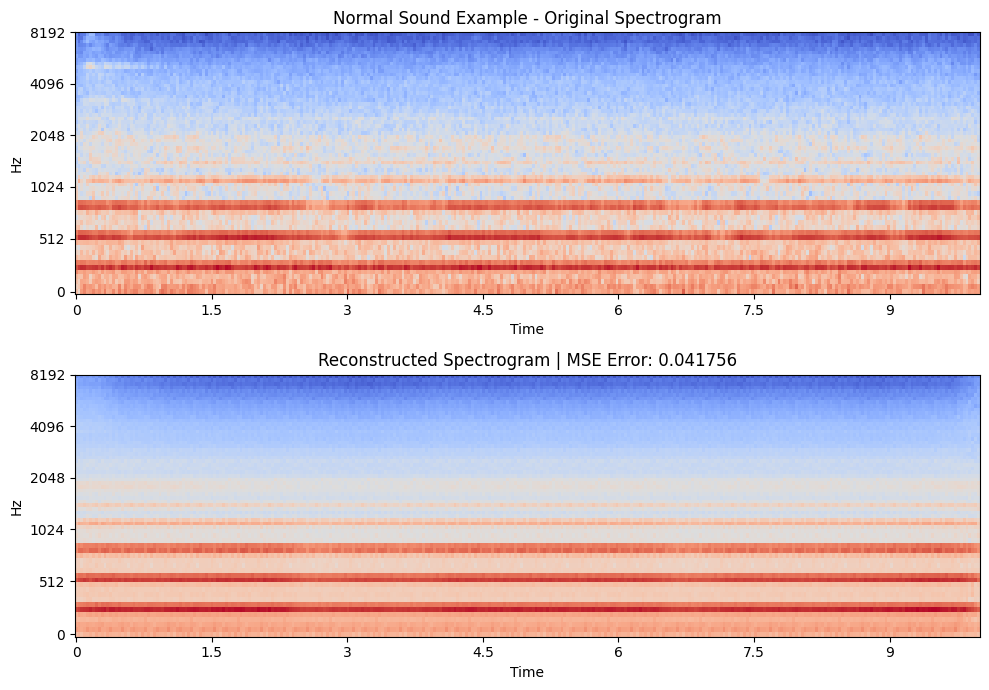

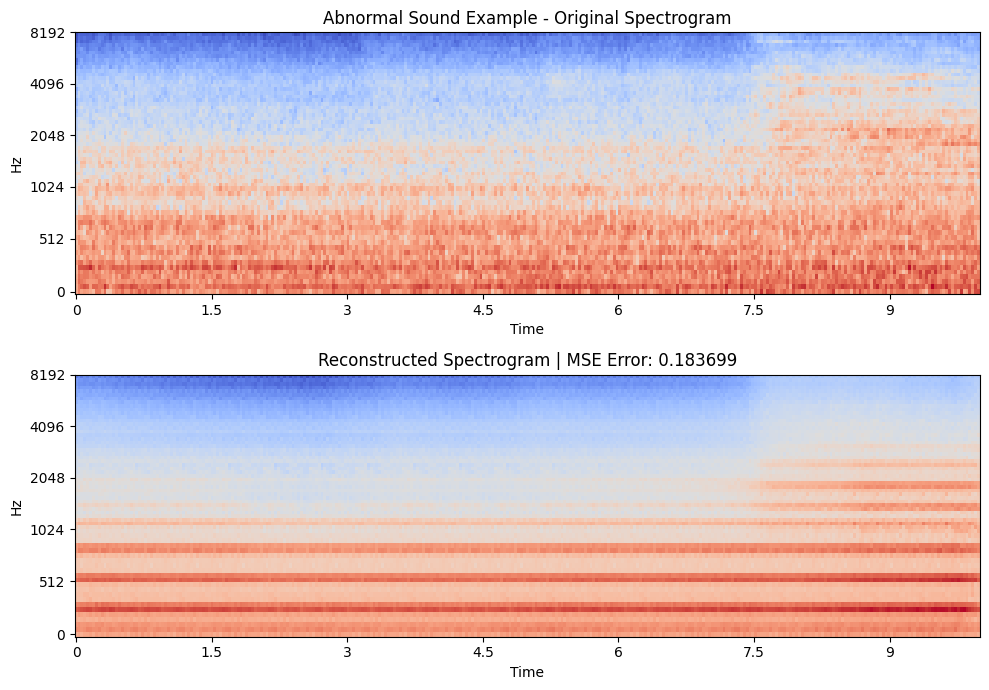

In [7]:
import matplotlib.pyplot as plt
# --- 6: Evaluation and Visualization ---
# Load the saved model
model.load_state_dict(torch.load('cae_autoencoder.pth'))
model.eval() # Set the model to evaluation mode

# 1. Determine the anomaly threshold using the normal test data
print("\nDetermining anomaly threshold...")
normal_errors = []
with torch.no_grad():
    for data, _ in tqdm(test_normal_dataset, desc="Calculating normal errors"):
        inputs = data.unsqueeze(0).to(DEVICE)
        outputs = model(inputs)
        
        # Crop the output to match the input's exact size
        target_size = inputs.size()[2:]
        outputs = outputs[:, :, :target_size[0], :target_size[1]]
        
        error = criterion(outputs, inputs).item()
        normal_errors.append(error)

threshold = np.mean(normal_errors) + 3 * np.std(normal_errors)
print(f"Anomaly threshold determined: {threshold:.6f}")

# 2. Test the model on the full test set
print("\nEvaluating model on the full test set...")
y_true = []
y_pred = []
with torch.no_grad():
    for data, label in tqdm(test_loader, desc="Evaluating test set"):
        inputs = data.to(DEVICE)
        outputs = model(inputs)
        
        target_size = inputs.size()[2:]
        outputs = outputs[:, :, :target_size[0], :target_size[1]]
        
        # Calculate reconstruction error for each item in the batch
        errors = torch.mean((outputs - inputs)**2, dim=[1, 2, 3])
        
        # Classify based on the threshold (0 = Abnormal, 1 = Normal)
        preds = [0 if e > threshold else 1 for e in errors]
        
        y_pred.extend(preds)
        y_true.extend(label.tolist())

# 3. Show classification report
print("\n--- FINAL CLASSIFICATION REPORT (CAE Model) ---")
print(classification_report(y_true, y_pred, target_names=["Abnormal", "Normal"]))

# 4. Visualize a normal vs. abnormal reconstruction
def visualize_reconstruction(dataset, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
    data, _ = dataset[0] # Take the first sample
    inputs = data.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        outputs = model(inputs)
        target_size = inputs.size()[2:]
        outputs = outputs[:, :, :target_size[0], :target_size[1]]
        error = criterion(outputs, inputs).item()

    ax1.set_title(f"{title} - Original Spectrogram")
    librosa.display.specshow(data.squeeze(0).cpu().numpy(), sr=16000, hop_length=512, ax=ax1, x_axis='time', y_axis='mel')
    
    ax2.set_title(f"Reconstructed Spectrogram | MSE Error: {error:.6f}")
    librosa.display.specshow(outputs.squeeze(0).squeeze(0).detach().cpu().numpy(), sr=16000, hop_length=512, ax=ax2, x_axis='time', y_axis='mel')
    
    fig.tight_layout()
    plt.show()

print("\n--- VISUALIZATION ---")
visualize_reconstruction(test_normal_dataset, "Normal Sound Example")
visualize_reconstruction(test_abnormal_dataset, "Abnormal Sound Example")